<img src="http://www.organicdatacuration.org/linkedearth/images/5/51/EarthLinked_Banner_blue_NoShadow.jpg">
# A jupyter Notebook for spectral analysis of time-uncertain marine data

# Table of Contents
* [Introduction](#introduction)
* [Running this Notebook](#run)
* [Import a LiPD file](#import)
* [Set Up](#setup)
    * [Get the data and metadata](#data)
    * [Reservoir Age Correction](#"reservoir)
    * [Bcrhon data and metadata](#Bchronsetup)
* [Bchron Run](#Bchronrun)
    * [Check You work](#Bchronrun)
    * [Age Model Plot](#agemodelplot)
* [Spectral Analysis](#spectralanalysis)
    * [Summary](#summary)
* [Programmer's corner](#corner)


# Introduction <a id="introduction"></a>

This notebook works through the step of obtaining an ensemble of possible age models for the marine chronology and obtain the time-uncertain spectrum for the time series.

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**NOTE**</p>
<p>Please cite the follwing contributors for Bchron and the z-wavelet</p>

<p>Haslett, J., Parnell, A. (2008). <i>A simple monotone process with application to radiocarbon-dated depth chronologies.</i> Journal of the Royal Statistical Society: Series C (Applied Statistics), 57, 4, 1467-9876. doi: <a href="http://dx.doi.org/10.1111/j.1467-9876.2008.00623.x">10.1111/j.1467-9876.2008.00623.x</a>
</p>
</div>

# Running this Notebook <a id="run"></a>

### Software

1. Jupyter Notebook
2. Python 3.4+ with the following modules:
    1. lipd (pip install lipd)
    2. numpy (standard with Anaconda Install)
    3. pandas (standard with Anaconda Install)
    4. matplotlib (standard with Anaconda Install)
3. An up-to-date version of R installed on your computer
4. The Bchron package. In a R console, type install.packages('Bchron')

### Record
A record in LiPD format. This notebook assumes that the column are organized using this format. To learn more about LiPD and utilities to format your dataset, vist this <a href="https://github.com/nickmckay/LiPD-utilities">page</a>. 

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**NOTE**</p>
<p> A Welcome to LiPD guide is also available in a Jupyter Notebook, created in the root directory of your computer when you intalled the lipd module.
</p>
</div>

# Import a LiPD file <a id="import"></a>


In [1]:
# Import the LiPD package and locate your files
from lipd.start import *

Where are your files stored?
1. Current Directory
2. Browse Computer
3. Downloads folder
4. Notebooks folder

Option: 4


In [2]:
# Load the LiPD file
loadLipds()

Found: 1 LiPD file(s)
processing: MD02-2515.McClymont.2012.lpd
Process Complete


# Set-up <a id="setup"></a>

## Get the data and metadata <a id="data"></a>

In [3]:
import sys

# Get the metadata (To display lat/lon)

lipd_m = getMetadata("MD02-2515.McClymont.2012.lpd")

if not 'properties' in lipd_m['geo']:
    record = input("Enter the name of your record: ")
else:    
    record = lipd_m['geo']['properties']['siteName']

# Get the paleodata in a Panda DataFrame for ease of use

df_data_dict = filter_dfs("paleo measurement")
table_instance = 0
for  key, value in df_data_dict.items():
    if "measurement" in key:
        table_instance += 1
if table_instance == 1:
    for  key, value in df_data_dict.items():
        if "measurement" in key:
            df_data_l = value
            table_name = key
elif table_instance == 0:
    sys.exit("No DataMeasurementTable available.")
else:
    print("There is more than one PaleoMeasurementTable available for this record.")
    for key, value in df_data_dict.items():
        if "measurement" in key:
            print(key)
            print(value)
    print("Which Table would you like to use?")
    for key, value in df_data_dict.items():
        if "measurement" in key:
            print(key)
    table_name = input("Enter the table name: ")
    df_data_l = df_data_dict[table_name]

Process Complete
Process Complete


In [4]:
# Get the chrondata in a panda dataframe for ease of use

df_data_dict = filter_dfs("chron measurement")
table_instance = 0
for  key, value in df_data_dict.items():
    if "measurement" in key:
        df_chron_l = value
        table_instance += 1
if table_instance == 1:
    for  key, value in df_data_dict.items():
        if "measurement" in key:
            df_chron_l = value        
elif table_instance == 0:
    sys.exit("No ChronMeasurementTable available.")
else:
    print("There is more than one ChronMeasurementTable available for this record.")
    for key, value in df_data_dict.items():
        if "measurement" in key:
            print(key)
            print(value)
    print("Which Table would you like to use?")
    for key, value in df_data_dict.items():
        if "measurement" in key:
            print(key)
    table_name = input("Enter the table name: ")
    df_chron_l = df_data_dict[table_name]

Process Complete


In [5]:
# Get the radiocarbon and radiocarbon uncertainty

if not 'age14C' in df_chron_l:
    print('The LiPD file did not use the proper nomenclature.')
    print('Please, identify the columns in which the' +
            ' radiocarbon and associated uncertainty data are stored.')
    counter = 0
    for i in list(df_chron_l):
        print(counter, ": ", i)
        counter += 1
    radio_input = int(input("Enter the number of the column" +
        " containing the radiocarbon data: "))
    radiocarbon = df_chron_l.iloc[:,radio_input]
    radioU_input = int(input("Enter the number of the column" +
        " containing the radiocarbon uncertainty: "))
    radiocarbonU = df_chron_l.iloc[:,radioU_input]
else:
    radiocarbon = df_chron_l.age14C
    radiocarbonU = df_chron_l.age14Cuncertainty

In [6]:
# Create a working directory

print("Enter the name of the new directory for the age model.")
print("If the directory doesn't exit, a folder will be created.")
print("If the directory already exists, files with the same name will be automatically overridden.")
print("If you want to create a different age model with different parameters, create a new directory.")
newfolder = input("Enter the name of the working directory for the new age model: ")

dir = os.getcwd()+'/'+newfolder
# Check whether the directory exists. If yes, print a warning
if not os.path.exists(dir):
    os.makedirs(dir)
else:    
    print("This directory already exists. All files will be overridden!")

Enter the name of the new directory for the age model.
If the directory doesn't exit, a folder will be created.
If the directory already exists, files with the same name will be automatically overridden.
If you want to create a different age model with different parameters, create a new directory.
Enter the name of the working directory for the new age model: AgeModel2


## Reservoir Age Correction <a id="reservoir"></a>

Apply a reservoir age correction on top of the standard correction to the measured radiocarbon. The radiocarbon data for the local correction &#916;R is taken from the 14CHRONO <a href="http://intcal.qub.ac.uk/marine/">website</a> and using the mean and standard error of the mean as the reservoir age correction and associated error.

In [7]:
# Get the latitude and longitude from the metadata

print("Latitude: " + str(lipd_m.get('geo').get('geometry').get('coordinates')[0]))
print("Longitude: " + str(lipd_m.get('geo').get('geometry').get('coordinates')[1]))

Latitude: 27.4835
Longitude: -112.0743


<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**NOTE**</p>
<p>The cell below will automatically "paste" the reservoir age correction table from this <a href="http://intcal.qub.ac.uk/marine/">website</a>. Enter the latitude/longitude from above and check the boxes 'ReservoirAge' and 'ReservoirErr'.</p>
<p> Select the entire table, **including** the headers.</p>
<p>Make sure that the table is the last item copied to the clipboard. You will get a chance to check it before continuing.</p>
<p>A copy of the table is automatically saved as a text file as part of the routine.</p>
<p> This **only** works with Safari or Google Chrome.</p>
</p>
</div>

In [12]:
import pandas as pd
import numpy as np  
import math

data = pd.read_clipboard()

# check your work

print("Don't forget to check your work!")
data 

Don't forget to check your work!


,MapNo,Lon,Lat,DeltaR,DeltaRErr,Reference,Locality,ReservoirAge,ReservoirErr,distance (km),
NaN,272,-112.0000,26.6700,337,55,"Goodfriend, :1997",Santa Inez Bay,637,56,91,
NaN,268,-111.0000,28.0000,356,50,"Goodfriend, :1997",Guaymas,658,50,120,
NaN,271,-111.0000,28.0000,450,50,"Goodfriend, :1997",Pajaro Island,738,51,120,
NaN,273,-111.0000,28.0000,400,50,"Ingram, B L :1996","Miramar Beach, Guaymas",688,51,120,
NaN,274,-111.0000,28.0000,226,50,"Goodfriend, :1997",Guaymas,528,50,120,
NaN,275,-111.0000,28.0000,153,50,"Goodfriend, :1997",Guaymas,515,50,120,
NaN,267,-110.8356,27.8196,460,50,"Goodfriend, :1997",Guaymas,828,51,128,
NaN,264,-111.9671,28.7869,536,53,"Berger, R, T:1966","Kino Bay, Sonora, Mexico",839,54,145,
NaN,265,-111.0000,26.0000,553,54,"Berger, R, T:1966","Carmen Is., Gulf of California, Mexico",901,54,196,
NaN,266,-111.0000,26.0000,450,60,"Ingram, B L :1996","Carmen Is., Gulf of California, Mexico",738,61,196,


In [13]:
# Calculate the average DR and standard error of the mean

corr = data.mean()['DeltaR']
corr_err = data.std()['DeltaR'] 
datapoints = data.shape[0]
max_dist = data.max()['distance (km)']

In [14]:
# Save to a text file

# Save the data to a textfile and generate a log
data.to_csv(os.path.join(dir,"Reservoir_Age.txt"),sep=' ', index=False, 
           header = True)
text_file = open(os.path.join(dir,"ReservoirAgeCorr_Info.txt"),"w")
text_file.write("The reservoir age correction was estimated from the \
chrono database.\n")
text_file.write("The reservoir age corrections was estimated on " +
                str(datapoints) + " datapoints.\n")
text_file.write("DR = " + str(math.floor(corr)) + " years.\n")
text_file.write("DR sigma = " + str(math.floor(corr_err)) + " years, expressed as the standard \
error of the mean.\n")
text_file.write("The maximum distance between the core location and \
measured reservoir ages is " + str(max_dist) + "km.\n")
text_file.close()  

In [15]:
# Perform the correction

corr_14C = np.floor((radiocarbon - corr).values)
err_14C = np.floor(np.sqrt(radiocarbonU**2 + corr_err**2).values)

## Prepare Bchron data and metadata <a id="Bchronetup"></a>

The next cell prepares the text file necessary for the Bchron run. 

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**NOTE**</p>
<p>This version of the Jupyter Notebook only allows radiocarbon data as tie points. 
</p>
</div>

In [16]:
# Generate the radiocarbon data for Bchron input

# Get the Id column
Id = []
for i in np.arange(0,corr_14C.size,1):
    Id.append(record + '_' + str(i+1))
    
if len([list(df_chron_l).index(header) for header in list(df_chron_l) if 'depth' in header.lower()]) > 1:
    print("Too many depth columns, refine the search")
    for header in list(df_chron_l):
        if 'depth' in header.lower():
            print(header)
    depth_column_name = input("Enter the name of the depth column of interest: ")
else:
    depth_column_name = [header for header in list(df_chron_l) if 'depth' in header.lower()][0]
    
# create the dataframe

radio = pd.DataFrame({'Id': Id,
                    'ages' : corr_14C,
                    'ageSds' : err_14C,
                    'position' : df_chron_l[depth_column_name],
                    'CalCurves' : 'marine13'})

In [17]:
# Save it to a text file

radio.to_csv(dir +'/'+ record +'_radiocarbon.txt', sep = '\t', index = False, header = True)

# Let's generate the positions for the new age model

df_data_l.to_csv(dir + '/' + record + '_depth.txt',
                columns = [header for header in list(df_data_l) if 'depth' in header.lower()], 
                index = False, header = False)

In [18]:
# Return some strings for use in Bchron
radio_text = record + '_radiocarbon.txt'
depth_text = record + '_depth.txt'

# Bchron Run <a id="Bchronrun"></a>

In [20]:
# Let Python and R communicate with each other

%load_ext rpy2.ipython

Setup some of Bchron optional arguments. Set the collection age of the core if known and the number of simulations to 10000 to get 1000 age model samples back

In [21]:
iter = 10000
max_t = -52

# Pass the needed variable into R

%R -i iter
%R -i dir
%R -i radio_text
%R -i depth_text
%R -i max_t
%R -i record

Perform the Bchron run and return the plot

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: inline

  warnings.warn(x, RRuntimeWarning)


  |============================================================| 100%

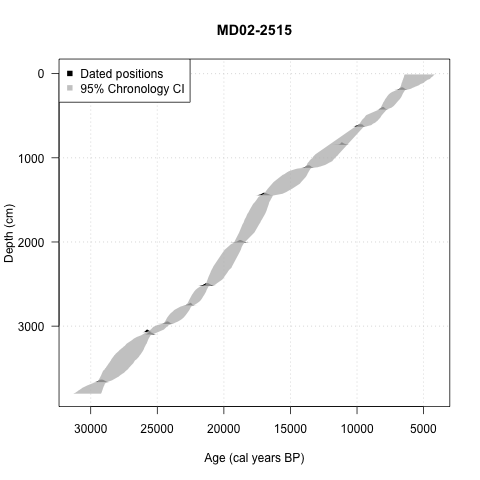

In [ ]:
%%R

library(Bchron)
setwd(dir)
library("Bchron", lib.loc="/Library/Frameworks/R.framework/Versions/3.2/Resources/library")
radiocarbon_data <- read.delim(radio_text)
depth_data <- read.table(depth_text, quote="\"")
run=Bchronology(ages=radiocarbon_data$ages,ageSds=radiocarbon_data$ageSds, 
                calCurves=radiocarbon_data$CalCurves,positions=radiocarbon_data$position,
                predictPositions=depth_data$V1,iterations=iter,extractDate=max_t)
plot(run,main=record,xlab='Age (cal years BP)',ylab='Depth (cm)',las=1)

## Check your work <a id="checkwork"></a>

It is possible that the radiocarbon dates provided by the original contributor were already corrected for the reservoir age of the ocean. A simple check is to plot the median age model from Bchron vs the original age model for the core.

If there is an evident ~400 year offset between the two, then enter "intcal13" instead of "marine13" in the radiocarbon table (the "radio" dataframe in this notebook).

In [ ]:
#Pass the depth and age variables back into python
depth = %R run$predictPositions
age = %R run$thetaPredict

# Calculate the mean
age_mean = np.mean(age, axis = 0)
age_median = np.median(age,axis = 0)

# Make sure that there is only one depth/age column, otherwise refine the search

if len([list(df_data_l).index(header) for header in list(df_data_l) if 'depth' in header.lower()]) > 1:
    print("Too many depth columns, refine the search")
    for header in list(df_data_l):
        if 'depth' in header.lower():
            print(header)
    depth_column_name = input("Enter the name of the depth column of interest: ")
else:
    depth_column_name = [header for header in list(df_data_l) if 'depth' in header.lower()][0]
    
if len([list(df_data_l).index(header) for header in list(df_data_l) if 'age' or 'yr' in header.lower()]) > 1: 
    print("Too many age columns, refine the search")
    for header in list(df_data_l):
        if 'age' or 'yr' in header.lower():
            print(header)
    age_column_name = input("Enter the name of the age column of interest: ")
else:
    age_column_name = [header for header in list(df_data_l) if 'age' in header.lower()][0]  
    
# Make the plot
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')
line1, = plt.plot(depth,age_median, label ='Bchron Median Age')
line2, = plt.plot(depth,age_mean, label ='Bchron Mean Age')
line3, = plt.plot(df_data_l[depth_column_name],df_data_l[age_column_name],label ='Original Age')
plt.xlabel('depth')
plt.ylabel('age')
plt.gca().invert_yaxis()
plt.legend(handles=[line1,line2,line3])    

## Age model plot <a id="agemodelplot"></a>

Plot the age model with the uncertainty cloud and save the resulting graph in the Figures subdirectory.

In [ ]:
# Calculate the quantiles
from scipy.stats.mstats import mquantiles
chronQ  = mquantiles(age, prob=[0.025, 0.5, 0.975], axis=0)
nchrons = age.shape[0]

# Plot it out
%matplotlib notebook
import seaborn as sns; 
import matplotlib.patches as mpatches
sns.set(style='whitegrid', palette='Set2')
ax = plt.axes()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.fill_between(depth, chronQ[0,:], chronQ[2,:], facecolor='Silver',edgecolor='Silver',lw=0.0)  # see http://stackoverflow.com/questions/14143092/why-does-matplotlib-fill-between-draw-edgelines-only-on-a-pdf
CI = mpatches.Patch(color='silver') # create proxy artist for labeling
lbl = ('95% CI','median','sample paths')
med, = ax.plot(depth,chronQ[1,],color = 'black', lw=3.0) 

#plot a few random paths
nl = 10
idx = np.random.randint(nchrons+1, size=nl)
l = plt.plot(depth,age[idx,:].T,lw=0.5,color = 'Purple')

# plot the legend
lg = plt.legend((CI,med,l[1]),lbl,loc='upper left'); lg.draw_frame(False)
plt.grid(axis='y'); plt.ylim(0,10000);  plt.xlim(0,200)
plt.xlabel(r'Depth in core (cm)',fontsize=14); plt.ylabel(r'Calendar Age (Yr BP)',fontsize=14);

In [ ]:
# OPTIONAL: save the figure
# Create the figure directory
if not os.path.exists(dir+'/Figures'):
    os.makedirs(dir+'/Figures')

# Save the figure
plt.savefig(dir+'/Figures/'+record+'_agemodel.eps',
                bbox_inches='tight',pad_inches = 0.25)

print("Once you're done saving the figure, make sure you press stop on the maplotlib notebook to stop interacting with it!")

# Spectral Analysis <a id="spectralanalyis"></a>

Use the Lomb-Scargle periodogram for unevenly-spaced time series from the scipy package. 

In [22]:
# Remove missing values for further analysis

if len([list(df_data_l).index(header) for header in list(df_data_l) if 'uk37' in header.lower()]) > 1: 
    print("Too many proxy columns, refine the search")
    for header in list(df_data_l):
        if 'uk37' in header.lower():
            print(header)
    y_axis_column = input("Enter the name of the proxy column of interest: ")
else:
    y_axis_column = [header for header in list(df_data_l) if 'mg/ca' in header.lower()][0]
    
print("Missing values are indicated by " + str(lipd_m['paleoData']['paleo']['paleoMeasurementTable']
      [[substring for substring in table_name.split('.') if 'table' in substring.lower()][0]]['missingValue']) + '.') 
print("Adapt the code in the cell below to filter the values out.")

Too many proxy columns, refine the search
sst - uk37
uk37
Enter the name of the proxy column of interest: uk37


IndexError: list index out of range

In [23]:
# Get the index of the actual values if Holocene
nan_index = []
for n,i in enumerate (df_data_l[y_axis_column]):
    if i > 0 and chronQ[1,n]<=10000:
        nan_index.append(n)
        
# Get the y values
y_values  = df_data_l[y_axis_column].iloc[nan_index]
# Get the x values
chronQ_nan = chronQ[:,nan_index]
age_nan = age[:,nan_index]

# Detrend and standardize the data
import scipy.signal as signal
y_values_detrended = signal.detrend(y_values)
y_values_std = (y_values_detrended-np.mean(y_values_detrended))/np.std(y_values_detrended)

In [24]:
# Define the array of frequencies for which to compute the periodogam

print('Warning! This cell takes 15-20 minutes to run depending on the length of the dataset')

ofac = 4 # oversampling value
hifac = 1 # highest frequency that can be analyzed/Nyquist frequency
int = np.nanmean(np.diff(mquantiles(age_nan, prob=[0.5], axis=0)))
step = ((2*int)**(-1))/(age_nan.shape[1]*ofac) # step size for the frequency verctor
f = np.arange(2*np.pi*step, 2*np.pi*(hifac*(2*int)**(-1)), step)

# compute the periodogram for each age model realization

pgram = np.zeros((age_nan.shape[0],f.shape[0])) # pre-allocate the space   
                 
for index in np.arange(0,age_nan.shape[0],1):
    pgram[index,:] = signal.lombscargle(age_nan[index,:],y_values_std,f)

pgram_norm = np.sqrt(4*(pgram/y_values.shape[0]))
pgramQ  = mquantiles(pgram_norm, prob=[0.025,0.975], axis=0)    

Warning! This cell takes 15-20 minutes to run depending on the length of the dataset


<IPython.core.display.Javascript object>


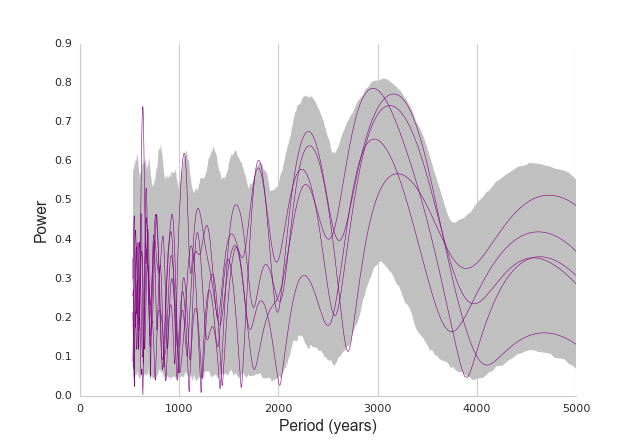

In [25]:
# Make a plot of the confidence bands along a few random periodograms

%matplotlib notebook
ax = plt.axes()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.fill_between(2*np.pi/f, pgramQ[1,:], pgramQ[0,:], facecolor='Silver',edgecolor='Silver',lw=0.0)  # see http://stackoverflow.com/questions/14143092/why-does-matplotlib-fill-between-draw-edgelines-only-on-a-pdf
CI = mpatches.Patch(color='silver') # create proxy artist for labeling
lbl = ('95% CI','sample paths')

#plot a few random paths
nl = 5
idx = np.random.randint(nchrons+1, size=nl)
l = plt.plot(2*np.pi/f,pgram_norm[idx,:].T,lw=0.5,color = 'Purple')

# plot the legend
#lg = plt.legend((CI,l[1]),lbl,loc='upper left'); lg.draw_frame(False)
plt.grid(axis='y'); plt.xlim(0,5000) #plt.ylim(0,10000);  plt.xlim(0,900)
plt.xlabel(r'Period (years)',fontsize=14); plt.ylabel(r'Power',fontsize=14);


In [26]:
# OPTIONAL: save the figure
# Create the figure directory
if not os.path.exists(dir):
    os.makedirs(dir+'/Figures')

# Save the figure
plt.savefig(dir+'/Figures/'+record+'_spectral.eps',
                bbox_inches='tight',pad_inches = 0.25)

print("Once you're done saving the figure, make sure you press stop on the maplotlib notebook to stop interacting with it!")

Once you're done saving the figure, make sure you press stop on the maplotlib notebook to stop interacting with it!


## Summary <a id="summary"></a>

Summarize the results below and export various csv file for further use

In [27]:
# Find the peaks for each Monte-Carlo age models and the percent variance in each band of interest
from detect_peaks import detect_peaks
from scipy.integrate import simps

# initiate the matrices
peak_sub1 = np.zeros(age_nan.shape[0])
peak_sub2 = np.zeros(age_nan.shape[0])
peak_sub3 = np.zeros(age_nan.shape[0])

percent_var1 = np.zeros(age_nan.shape[0])
percent_var2 = np.zeros(age_nan.shape[0])
percent_var3 = np.zeros(age_nan.shape[0])

for index in np.arange(0,age_nan.shape[0],1): #step over all the possible spectres 
    # Concentrate on the 900-1200 yr band
    pgram_sub1 = pgram_norm[index , np.min(np.where(2*np.pi/f<1200)):np.max(np.where(2*np.pi/f>900))]
    f_sub1 = f[np.min(np.where(2*np.pi/f<1200)):np.max(np.where(2*np.pi/f>900))]
    ind_sub1 = detect_peaks(pgram_sub1, show = False, mpd = pgram_sub1.shape[0])
    if not ind_sub1:
        peak_sub1[index] = np.nan
        percent_var1[index]= np.nan
    else:    
        peak_sub1[index] = 2*np.pi/f_sub1[ind_sub1]
        percent_var1[index] = simps(pgram_sub1,f_sub1)/simps(pgram_norm[index,:], f)

    # Concentrate on the 1200-2000 yr band
    pgram_sub2 = pgram_norm[index , np.min(np.where(2*np.pi/f<2000)):np.max(np.where(2*np.pi/f>1200))]
    f_sub2 = f[np.min(np.where(2*np.pi/f<2000)):np.max(np.where(2*np.pi/f>1200))]
    ind_sub2 = detect_peaks(pgram_sub2, show = False, mpd = pgram_sub2.shape[0])
    if not ind_sub2:
        peak_sub2[index] = np.nan
        percent_var2[index]= np.nan
    else:    
        peak_sub2[index] = 2*np.pi/f_sub2[ind_sub2]
        percent_var2[index] = simps(pgram_sub2,f_sub2)/simps(pgram_norm[index,:], f)

    # Concentrate on the 2000-3000 yr band
    pgram_sub3 = pgram_norm[index , np.min(np.where(2*np.pi/f<3000)):np.max(np.where(2*np.pi/f>2000))]
    f_sub3 = f[np.min(np.where(2*np.pi/f<3000)):np.max(np.where(2*np.pi/f>2000))]
    ind_sub3 = detect_peaks(pgram_sub3, show = False, mpd = pgram_sub3.shape[0])
    if not ind_sub3:
        peak_sub3[index] = np.nan
        percent_var3[index]= np.nan
    else:    
        peak_sub3[index] = 2*np.pi/f_sub3[ind_sub3]
        percent_var3[index] = simps(pgram_sub3,f_sub3)/simps(pgram_norm[index,:], f)

In [28]:
# Export the age as csv
np.savetxt(record+"_age.csv",age_nan,delimiter=",")
np.savetxt(record+"_depth.csv",depth[nan_index],delimiter=",")

# Create a text file summarizing the statistics of the spectral analysis
text_file = open(os.path.join(dir,record+"_Spectral_Analysis_Summary.txt"),"w")
text_file.write("900-1200 year band")
text_file.write("\n\nThere is a peak in this frequency band in " + \
                str(round(np.count_nonzero(~np.isnan(peak_sub1))/age_nan.shape[0]*100,0))+ \
                "% of the Monte-Carlo simulations.")
text_file.write("\nThe median periodicity is " + str(round(mquantiles(peak_sub1,prob=0.5,axis=0)[0],0)) +\
               " years with a 95% confidence band of " + str(round(mquantiles(peak_sub1,prob=0.025,axis=0)[0],0)) +\
               " - " +str(round(mquantiles(peak_sub1,prob=0.975,axis=0)[0],0)) + " years.")
text_file.write("\nThis frequency band represents between " + str(round(np.nanmin(percent_var1*100),1)) +\
                " and " + str(round(np.nanmax(percent_var1*100),1))+ "% of the total variance.")
text_file.write("\n\n1200-2000 year band")
text_file.write("\n\nThere is a peak in this frequency band in " + \
                str(round(np.count_nonzero(~np.isnan(peak_sub2))/age_nan.shape[0]*100,0))+ \
                "% of the Monte-Carlo simulations.")
text_file.write("\nThe median periodicity is " + str(round(mquantiles(peak_sub2,prob=0.5,axis=0)[0],0)) +\
               " years with a 95% confidence band of " + str(round(mquantiles(peak_sub2,prob=0.025,axis=0)[0],0)) +\
               " - " +str(round(mquantiles(peak_sub2,prob=0.975,axis=0)[0],0)) + " years.")
text_file.write("\nThis frequency band represents between " + str(round(np.nanmin(percent_var2*100),1)) +\
                " and " + str(round(np.nanmax(percent_var2*100),1))+ "% of the total variance.")
text_file.write("\n\n2000-3000 year band")
text_file.write("\n\nThere is a peak in this frequency band in " + \
                str(round(np.count_nonzero(~np.isnan(peak_sub3))/age_nan.shape[0]*100,0))+ \
                "% of the Monte-Carlo simulations.")
text_file.write("\nThe median periodicity is " + str(round(mquantiles(peak_sub3,prob=0.5,axis=0)[0],0)) +\
               " years with a 95% confidence band of " + str(round(mquantiles(peak_sub3,prob=0.025,axis=0)[0],0)) +\
               " - " +str(round(mquantiles(peak_sub3,prob=0.975,axis=0)[0],0)) + " years.")
text_file.write("\nThis frequency band represents between " + str(round(np.nanmin(percent_var3*100),1)) +\
                " and " + str(round(np.nanmax(percent_var3*100),1))+ "% of the total variance.")
text_file.close() 

# Create another text file to look for the number easily
text_file = open(os.path.join(dir,record+"_spectral.txt"),"w")
text_file.write(str(round(mquantiles(peak_sub1,prob=0.5,axis=0)[0],0)) + "," +\
               str(round(mquantiles(peak_sub1,prob=0.975,axis=0)[0],0)-round(mquantiles(peak_sub1,prob=0.025,axis=0)[0],0))\
               + "," + str(round(np.count_nonzero(~np.isnan(peak_sub1))/age_nan.shape[0]*100,1)) + "," +\
               str(round(np.nanmean(percent_var1*100),1))) 
text_file.write("\n"+ str(round(mquantiles(peak_sub2,prob=0.5,axis=0)[0],0)) + "," +\
               str(round(mquantiles(peak_sub2,prob=0.975,axis=0)[0],0)-round(mquantiles(peak_sub2,prob=0.025,axis=0)[0],0))\
               + "," + str(round(np.count_nonzero(~np.isnan(peak_sub2))/age_nan.shape[0]*100,1)) + "," +\
               str(round(np.nanmean(percent_var2*100),1))) 
text_file.write("\n"+ str(round(mquantiles(peak_sub3,prob=0.5,axis=0)[0],0)) + "," +\
               str(round(mquantiles(peak_sub3,prob=0.975,axis=0)[0],0)-round(mquantiles(peak_sub3,prob=0.025,axis=0)[0],0))\
               + "," + str(round(np.count_nonzero(~np.isnan(peak_sub3))/age_nan.shape[0]*100,1)) + "," +\
               str(round(np.nanmean(percent_var3*100),1)))
text_file.close()   

# Programmer's corner <a id="corner"></a>

Use the cell below to have a look at the data and variables in the workspace

In [27]:
whos

Variable               Type                  Data/Info
------------------------------------------------------
CI                     Patch                 Patch'>
COMPARISONS            dict                  n=6
Convert                type                  <class 'lipd.pkg_resource<...>eseries.Convert.Convert'>
DATA_FRAMES            list                  n=8
EMPTY                  list                  n=9
Id                     list                  n=4
LiPD                   type                  <class 'lipd.pkg_resources.lipd.LiPD.LiPD'>
LiPD_Library           type                  <class 'lipd.pkg_resource<...>PD_Library.LiPD_Library'>
NOAA_DATA_LINES        list                  n=3
NOAA_EMPTY             list                  n=5
NOAA_KEYS              list                  n=3
NOAA_VAR_LINES         list                  n=8
RE_SHEET               SRE_Pattern           re.compile('(paleo|chron)<...>]*(\\d+)', re.IGNORECASE)
TS                     function              <functio

In [37]:
np.array([[depth[nan_index]],[age_nan]])

array([[ array([  12.5,   17.5,   22.5,   27.5,   32.5,   37.5,   42.5,   47.5,
         52.5,   57.5,   62.5,   67.5,   72.5,   77.5,   82.5,   87.5,
         92.5,   97.5,  102.5,  107.5,  112.5,  117.5,  127.5,  137.5,
        142.5,  147.5,  152.5,  167.5,  177.5,  187.5,  197.5,  202.5,
        207.5,  212.5,  217.5,  222.5,  227.5,  232.5,  237.5,  242.5,
        247.5,  252.5,  257.5,  262.5,  267.5,  272.5,  277.5,  282.5])],
       [ array([[  1704.,   1905.,   2105., ...,   8384.,   8456.,   8527.],
       [  1371.,   1458.,   1544., ...,  10389.,  10473.,  10558.],
       [  1453.,   1600.,   1747., ...,  10116.,  10210.,  10304.],
       ..., 
       [  1435.,   1596.,   1756., ...,   9701.,   9859.,  10018.],
       [  1393.,   1536.,   1680., ...,   7125.,   7224.,   7506.],
       [  1398.,   1555.,   1711., ...,   9687.,   9847.,  10008.]])]], dtype=object)

In [18]:
age

array([[  4751.,   4774.,   4880., ...,  29271.,  29274.,  29275.],
       [  5568.,   5581.,   5600., ...,  29592.,  29612.,  29625.],
       [  5638.,   5664.,   5697., ...,  29937.,  29951.,  29960.],
       ..., 
       [  5899.,   5908.,   5920., ...,  32087.,  32117.,  32137.],
       [  5680.,   5684.,   5744., ...,  29762.,  29772.,  29778.],
       [  5009.,   5030.,   5057., ...,  29874.,  29886.,  29893.]])